In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import correlate
import os
import heapq
arr = np.load("./PEMS04/pems04.npz")
print(dir(arr))
for key in arr.keys():
    print(key)
#print(arr['data'])


['__abstractmethods__', '__class__', '__contains__', '__del__', '__delattr__', '__dict__', '__dir__', '__doc__', '__enter__', '__eq__', '__exit__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__iter__', '__le__', '__len__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__reversed__', '__setattr__', '__sizeof__', '__slots__', '__str__', '__subclasshook__', '__weakref__', '_abc_impl', '_files', 'allow_pickle', 'close', 'f', 'fid', 'files', 'get', 'items', 'iteritems', 'iterkeys', 'keys', 'pickle_kwargs', 'values', 'zip']
data


In [2]:
arr['data'].shape

(16992, 307, 3)

In [13]:
closest = []
heapq.heapify(closest)
heapq.heappush(closest,(115,"H"))
heapq.heappush(closest,(116,"I"))
heapq.heappush(closest,(117,"J"))
heap_items = list(map(lambda x: x[1], [heapq.heappop(closest) for i in range(len(closest))]))
print(heap_items)

['H', 'I', 'J']


In [19]:
def average(L):
    if len(L) == 0:
        return 0
    return sum(L)/len(L)
def add_on_reciprocal(diff):
    if diff == 0:
        add_on = float('inf')
    else:
        add_on = 1/diff
    return add_on

# Noise Reduction Techniques
def linear_smoother(ts, num_neighbors, weight_method="gaussian"):
    averaged_points = []
    for i in range(len(ts)):
        closest = []
        heapq.heapify(closest)
        downward, upward = i, i
        if weight_method == "gaussian":
            under_neighbors = i-num_neighbors
            above_neighbors = i+num_neighbors
            while under_neighbors <= downward and under_neighbors >= 0 and\
                  i+num_neighbors >= upward and above_neighbors < len(ts):
                # sorts by the first element of tuple
                if len(closest) >= num_neighbors:
                    heapq.heappop(closest)
                else:
                    heapq.heappush(closest,(add_on_reciprocal(i-downward),ts[downward]))
                if (len(closest) >= num_neighbors):
                    heapq.heappop(closest)
                else:
                    heapq.heappush(closest,(add_on_reciprocal(upward-i), ts[upward]))  
                
                downward -= 1
                upward += 1
            while under_neighbors <= downward and under_neighbors >= 0:
                if len(closest) >= num_neighbors:
                    heapq.heappop(closest)
                else:
                    heapq.heappush(closest,(add_on_reciprocal(i-downward),ts[downward]))
                downward -= 1           
            while i+num_neighbors >= upward and above_neighbors < len(ts):
                if len(closest) >= num_neighbors:
                    heapq.heappop(closest)
                else:
                    heapq.heappush(closest,(add_on_reciprocal(upward-i), ts[upward]))   
                upward += 1
            heap_items = list(map(lambda x: x[1], [heapq.heappop(closest) \
                                                       for i in range(len(closest))]))
            averaged_points.append(average(heap_items))
        else:
            # rather than a weighted average of nearest data points, 
            # we take ordinary average.
            pass
    return averaged_points


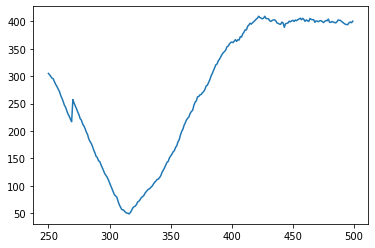

In [23]:
plt.plot(range(250,500),linear_smoother(pems8_data[250:500,0,0],20, "gaussian"))

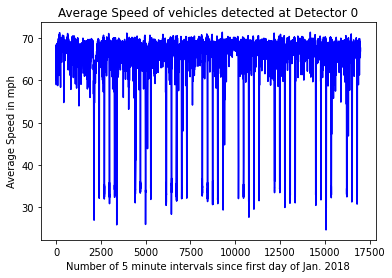

In [4]:
# Third entry in the 3D array contains average speed - every 5 minutes between observations.
# In major metropolitan areas of California.
# 307 detectors
detector = 0
avg_speed_pems4 = plt.plot(list(range(len(arr['data'][:,0]))),arr['data'][:,detector,2], color="blue")
pems4_speed_title = plt.title("Average Speed of vehicles detected at Detector {}".format(detector))
pems4_speed_x = plt.xlabel("Number of 5 minute intervals since first day of Jan. 2018")
pems4_speed_y = plt.ylabel("Average Speed in mph")

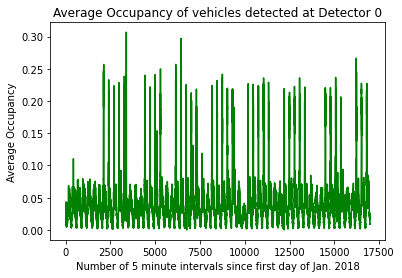

In [5]:
# Second entry - occupancy - fraction of time a vehicle is over a detector.
detector = 0
pems4_occupancy_title = plt.title("Average Occupancy of vehicles detected at Detector {}".format(detector))
pems4_occupancy_x = plt.xlabel("Number of 5 minute intervals since first day of Jan. 2018")
pems4_occupancy_y = plt.ylabel("Average Occupancy")
pems4_occupancy = plt.plot(list(range(len(arr['data'][:,0]))),arr['data'][:,detector,1],color="green")

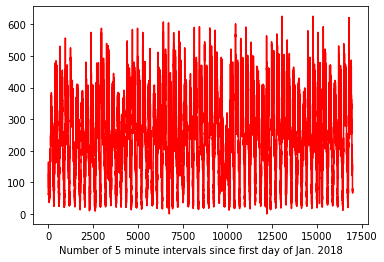

In [6]:
# First entry - flow - number of vehicles passing over the detector in 30 second period.
# 

pems4_flow = plt.plot(list(range(len(arr['data'][:,0]))),arr['data'][:,0,0],color="red")
pems4_flow_x = plt.xlabel("Number of 5 minute intervals since first day of Jan. 2018")
pems4_flow_y = plt.ylabel("")

In [7]:
arr_pems8 = np.load("./PEMS08/pems08.npz")
pems8_data = arr_pems8["data"]

In [8]:
pems8_data.shape

(17856, 170, 3)

In [9]:
def ma(ts,window):
    ts_points = []
    for i in range(window,len(ts)):
        ts_points.append(np.sum(ts[(i-window):i])/window)
    return ts_points

def norm(vec):
    return np.sqrt(np.sum([x**2 for x in vec]))

def cosine_sim(vec1,vec2):
    return np.dot(vec1,vec2)/(norm(vec1)*norm(vec2))

def deltas(vec):
    diffs = []
    for i in range(1,len(vec)):
        diffs.append(vec[i]-vec[i-1])
    return diffs
# cosine similarity between pairwise difference vectors (x_i-x_{i-1})
def most_similar_segments(start_idx,end_idx,ts,k,compute_diff=True,avg_diff=False):
    cmp_window = ts[start_idx:end_idx]
    if compute_diff:
        cmp_window = deltas(cmp_window)
    window_size = end_idx-start_idx
    L = []
    heapq.heapify(L)
    num_segments = 0
    sim_to_region = dict()
    seen_segments = []
    for i in range(window_size,len(ts)):
        segment = ts[(i-window_size):i]
        if compute_diff:
            segment = deltas(segment)
        if avg_diff:
            sim = np.sum(np.array(cmp_window)-np.array(segment))/len(cmp_window)
        else:
            sim = correlate(cmp_window,segment)[0]
            #sim = cosine_sim(cmp_window,segment)
        sim = round(sim,6)
        if sim == -68774.0:
            print("Sim Negative",i,num_segments)
#         if i-window_size in set([2510,2259,2008,1757,1506,
#                                 1255,1004,753,502,0]):
#                 print(i-window_size,sim)
#         else:
#                 print("LOWER?:",i-window_size,sim)
        if len(seen_segments) != 0:
            if seen_segments[-1][-1] >= i-window_size:
                continue
        if num_segments < k:
            sim_to_region[sim] = list(range(i-window_size,i))
            heapq.heappush(L,sim)
            num_segments += 1
        else:
            least_sim_largest_dist = heapq.nsmallest(1,L)[0]
#             print("Keeping size:",len(L))
#             print("least_similar",least_sim_largest_dist)
            if sim >= least_sim_largest_dist: # number of segments exceeds k
#                 sim_to_region[sim] = list(range(i-window_size,i))
                # need to remove the least similar region if similarity is greater than 
                # the least similar one in the heap.
                sim_to_region[sim] = list(range(i-window_size,i))
                heapq.heappush(L,sim)
                del sim_to_region[least_sim_largest_dist]
                # here we pop the smallest element from L.
                heapq.heappop(L)
        seen_segments.append([i-window_size,i])
    print(sim_to_region.keys())
    return list(sim_to_region.values())

In [10]:
# implement basic algorithm from thesis writeup.
def find_greatest_change(data,chunk_sizes):
    start_times = []
    for size in chunk_sizes:
        max_change = 0

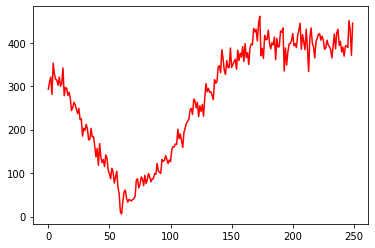

In [11]:
# list(pems8_data[:,0,2])[250:375]
plt.plot(list(range(250)),pems8_data[250:500,0,0],color="red")

In [12]:
sim_segs = most_similar_segments(250,500, list(pems8_data[:,0,0]),20)

Sim Negative 501 1
dict_keys([15556.0, 20213.0, 9955.0, 15888.0, 25873.0, 14238.0, 12696.0, 11572.0, 16725.0, 7422.0, 21580.0, 12177.0, 14460.0, 31210.0, 22550.0, 10583.0, 37514.0, 40820.0, 9352.0, 9022.0])


In [13]:
# PEMS08 average speeds
def plot_similar_cyclic_regions(indices, ts):
    indices = sorted(indices, key=lambda x: x[0])
    lsts_idx_excluded = []
    curr_end = None
    plt.plot(list(range(250)),pems8_data[250:500,0,0],color="yellow")
    plt.figure(figsize=(3, 3))
    # we assume non-overlapping indices
    for i,index_lst in enumerate(indices):
        plt.plot(index_lst,ts[index_lst],color="purple")
        if i == len(indices)-1:
            indices_to_end = list(range(index_lst[-1],len(ts)))
            plt.plot(indices_to_end,
                     ts[indices_to_end],
                    color="cyan")
        else:
            indices_in_between = list(range(index_lst[-1],indices[i+1][0]))
            plt.plot(indices_in_between,
                     ts[indices_in_between],
                    color="cyan")
        if i == 0 and index_lst[0] > 0:
            plt.plot(list(range(0,index_lst[0])),ts[:index_lst[0]],color="green")
        plt.figure(figsize=(3, 3))
    plt.show()
# cyan is data in the time series that aren't part of the most similar regions.
# 

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


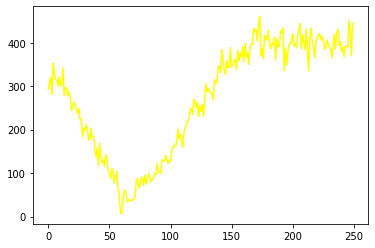

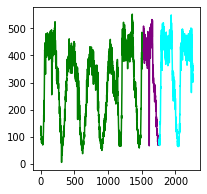

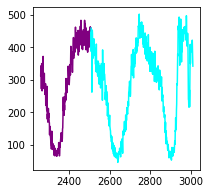

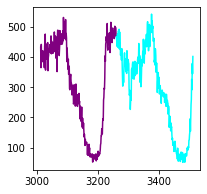

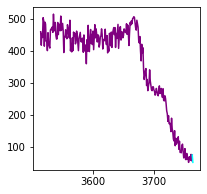

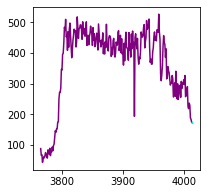

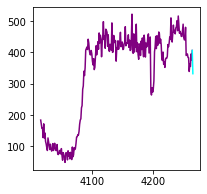

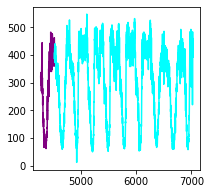

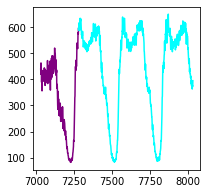

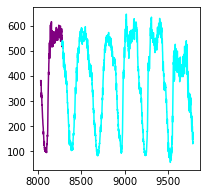

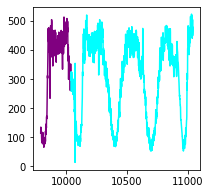

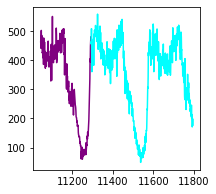

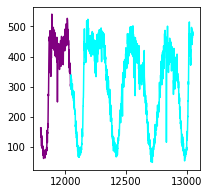

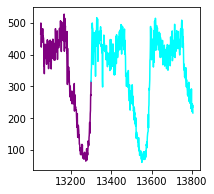

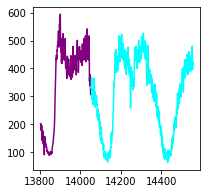

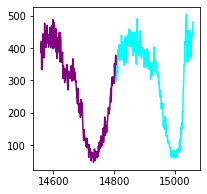

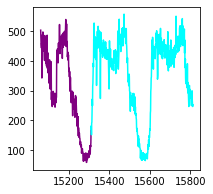

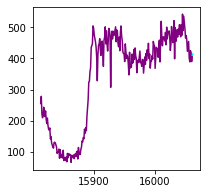

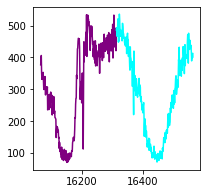

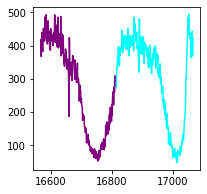

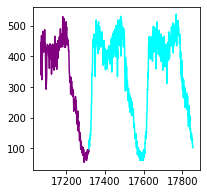

<Figure size 216x216 with 0 Axes>

In [14]:
plot_similar_cyclic_regions(sim_segs,pems8_data[:,0,0])

In [12]:
sim_segs_all = [[idx for idx in seg] for seg in sim_segs]

In [13]:
sim_segs_idx = [idx for seg in sim_segs for idx in seg]

In [14]:
print(len(set(pems8_data[sim_segs_idx,0,0])))
print(len(pems8_data[sim_segs_idx,0,0]))

496
5000


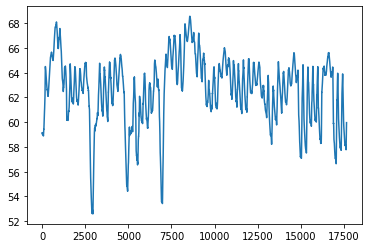

In [61]:
pems8_ma = ma(pems8_data[:,0,2],200)
plt.plot(list(range(len(pems8_ma))),pems8_ma)

In [ ]:
incomplete_highways_england_data = pd.read_csv("../")

In [13]:
predictions_ASTGCN = np.load('output_epoch_65_test.npz')

In [18]:
# Keys within the predictions output
for key in predictions_ASTGCN.keys():
    print(key)

input
prediction
data_target_tensor


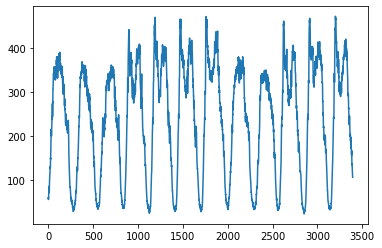

In [34]:
detector = 0
predicted_ts = predictions_ASTGCN["prediction"][:,detector,2]
prediction_plt = plt.plot(list(range(len(predicted_ts))),predicted_ts)

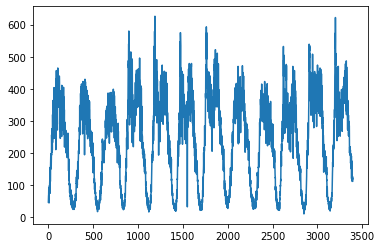

In [36]:
detector = 0
true_ts = predictions_ASTGCN["data_target_tensor"][:,detector,2]
plt.plot(list(range(len(true_ts))),true_ts)

In [33]:
def pairwise_diff(vec1,vec2):
    assert type(vec1) == type(vec2) and type(vec1) == np.ndarray
    return vec1-vec2

In [37]:
diffs = pairwise_diff(np.array(true_ts),np.array(predicted_ts))

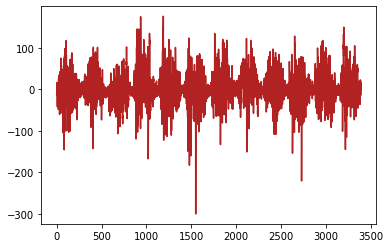

In [39]:
plt.plot(list(range(len(diffs))),diffs,color="firebrick")